In [1]:
import os
from google.colab import drive
from google.colab import files
import random
import pandas as pd
import time
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from torch.nn.modules.activation import LeakyReLU
from matplotlib.pyplot import figure
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install torchinfo
from torchinfo import summary

In [3]:
os.chdir("/content/data")

In [4]:
class ds_MPC(Dataset):
    def __init__(self, list_line):
        self.samples = []
        self.x_feas=[]
        for line in list_line:
            list_data=line[:-1].split(",")
            list_data=list(map(float, list_data))
            if list_data[3]==1:
                x1=list_data[0]
                x2=list_data[1]
                u=list_data[2]
                self.samples.append((np.array([x1,x2]),u))
                self.x_feas.append(np.array([x1,x2]))

    def set_x_feas(self):
      return self.x_feas

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [5]:
with open('tabledata.txt', 'r') as read_obj:
    Lines = read_obj.readlines()[1:]
ds_mpc=ds_MPC(Lines)
x_feas=ds_mpc.set_x_feas()

In [6]:
def init_weight(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class Model(nn.Module):
    def __init__(self, ngpu):
        super(Model, self).__init__()
        self.ngpu = ngpu
        self.nnModel = nn.Sequential(
            nn.Linear(2,32,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(32,128,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(128,32,bias=True),
            nn.LeakyReLU(0.2),
            nn.Linear(32,1,bias=True),
        )

    def forward(self, input):
        return self.nnModel(input)

In [7]:
net= Model("cuda").to("cuda")
net.apply(init_weight)

Model(
  (nnModel): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [8]:
summary(net)

NameError: ignored

In [ ]:
manualSeed=1
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(manualSeed)

In [ ]:
from tqdm import tqdm
def validation(net,dataloader_v):
  Error=[]
  net.eval()
  for i, dataj in enumerate(dataloader_t, 0):
      x=dataj[0].float().to("cuda")
      yhat=dataj[1].float().to("cuda")
      y=net(x)
      err_t=nn.L1Loss()(y.view(batch_size).float(),yhat.float())
      Error.append(err_t.item())
  return Error
def training(net,dataloader_t,num_epochs,step1,step2):
  Loss = []
  max_error=[]
  mean_error=[]
  std_error=[]
  net.train()
  for epoch in tqdm(range(num_epochs)):
      if epoch==0:
        lr=0.001
        beta1=0.9
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
      if epoch==step1:
        lr=0.0001
        beta1=0.9
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
      if epoch==step2:
        lr=0.00005
        beta1=0.9
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
      L_t=[]
      net.train()
      for i, dataj in enumerate(dataloader_t, 0):
          net.zero_grad()
          x=dataj[0].float().to("cuda")
          yhat=dataj[1].float().to("cuda")
          y=net(x)
          err_t=nn.L1Loss()(y.view(batch_size).float(),yhat.float())
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      err=np.mean(L_t)
      std=np.std(L_t)
      Loss.append([err,std])
      Error=validation(net,dataloader_v)
      max_error.append(np.max(Error))
      mean_error.append(np.mean(Error))
      std_error.append(np.std(Error))
      print("mean_error : {} et std : {} et error_max : {}".format(np.mean(Error),np.std(Error),np.max(Error)))
      #torch.save(net.state_dict(), "net/net_"+str(fold)+"_epoch_"+str(epoch)+".pth")
  return (Loss,max_error,mean_error,std_error)

In [ ]:
batch_size=32
num_workers=2
dataloader_t = torch.utils.data.DataLoader(ds_mpc,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v = torch.utils.data.DataLoader(ds_mpc,batch_size=1,shuffle=False,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

In [ ]:
Loss,max_error,mean_error,std_error=training(net,dataloader_t,50,10,25)

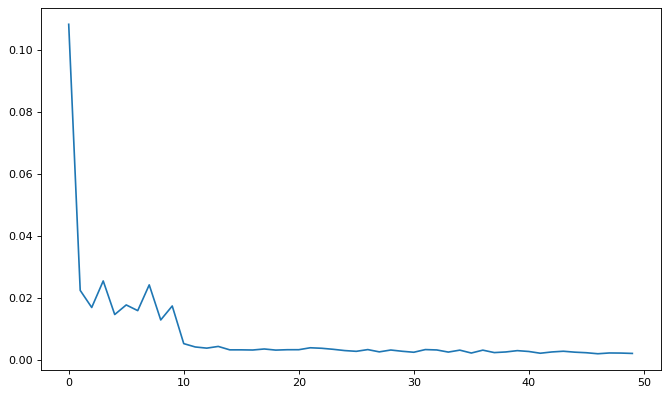

In [ ]:
figure(figsize=(10, 6), dpi=80)
plt.plot(max_error)

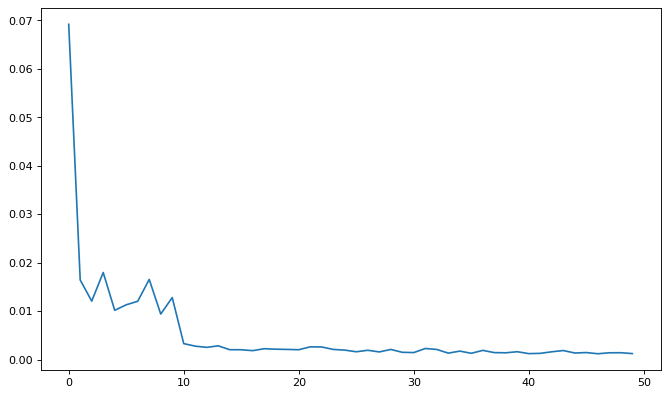

In [ ]:
figure(figsize=(10, 6), dpi=80)
plt.plot(mean_error)

In [ ]:
figure(figsize=(10, 6), dpi=80)
plt.plot(max_error)

In [13]:
A=np.array([[1,1],[0,1]])
B=np.array([1,1])
def closed_loop(x,net,N):
  net.eval()
  x_t=[x]
  u_t=[]
  for k in range(0,N):
    u=net(torch.from_numpy(x_t[-1]).float().to("cuda")).item()
    x_tp=A@x_t[-1]+B*u
    x_t.append(x_tp)
    u_t.append(u)
  return x_t,u_t

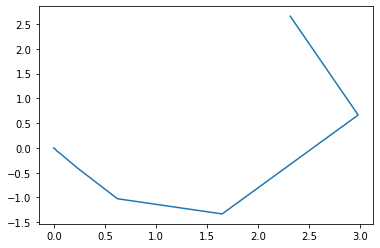

In [14]:
path,control=closed_loop(np.array([2.3156,2.658]),net,10)
x=[elem[0] for elem in path]
y=[elem[1] for elem in path]
plt.plot(x,y)

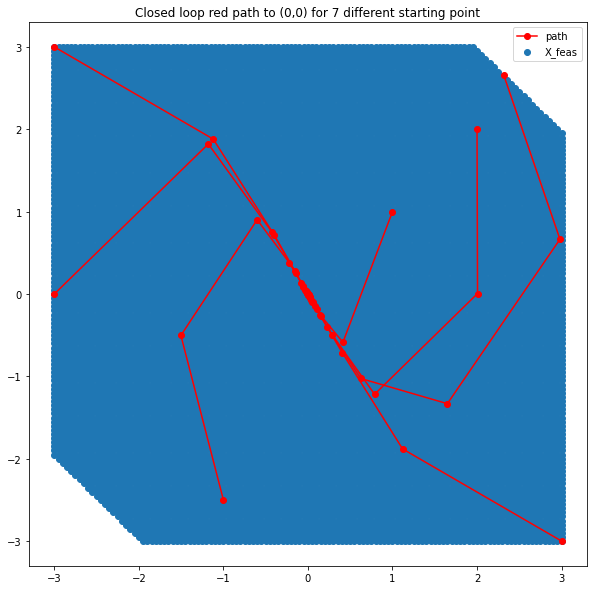

In [25]:
pts_verif=[np.array([-3,3]),np.array([3,-3]),np.array([2.3156,2.658]),np.array([1,1]),np.array([-1,-2.5]),np.array([-3,0]),np.array([2,2])]
x1=[elem[0] for elem in x_feas]
x2=[elem[1] for elem in x_feas]
plt.figure(figsize=(10,10))
plt.title('Closed loop red path to (0,0) for 7 different starting point')
plt.scatter(x1,x2,label='X_feas')
leg=True
for point in pts_verif:
  path,control=closed_loop(point,net,10)
  x=[elem[0] for elem in path]
  y=[elem[1] for elem in path]
  plt.plot(x,y,'o-',color='red',label='path')
  if leg==True:
    plt.legend()
    leg=False